# Проект Телеком
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

_Описание услуг_

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

## План выполнения проекта
Для выполнения данной работы нам необходимо решить задачу бинарной классификации. Ключевой метрикой является ROC-AUC. Минимальное значение метрики должно быть больше 0,85.

Этапы выполнения работы:

* Ознакомиться с имеющимися данными
* Провести исследовательский анализ данных
* Разбить данные на тренировочную и тестовую выборки
* Обучить и сравнить результаты работы линейной модели, модели случайного леса и модели градиентного бустинга
* Выбрать лучшую модель и подвести итоги работы

## Объявление переменных и загрузка библиотек

In [32]:
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import re

from scipy.stats import chi2_contingency

from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import catboost
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import (confusion_matrix, roc_curve, RocCurveDisplay, 
                             roc_auc_score, classification_report, auc)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 270223

## Знакомство с данными

In [2]:
def describe_df(data):
    print('Размер таблицы:')
    display(data.shape)
    print('='*10)
    print('Формат столбцов таблицы:')
    display(data.info())
    print('='*10)
    print('Описание переменных таблицы:')
    display(data.describe(include='all'))
    print('='*10)
    print('Начало таблицы:')
    display(data.head())
    print('='*10)

In [3]:
def camel_to_snake_case(data):
    list_of_colnames = list(data.columns)
    snake_case_list = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in list_of_colnames]
    return snake_case_list

In [4]:
try:
    contract = pd.read_csv('final_provider/contract.csv', index_col='customerID')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = 0
contract['TotalCharges'] = contract['TotalCharges'].astype('float')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], yearfirst=True)
contract['EndDate'] = contract['EndDate'].replace('No', np.nan)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], yearfirst=True)
contract.columns = camel_to_snake_case(contract)
describe_df(contract)

Размер таблицы:


(7043, 7)

Формат столбцов таблицы:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1869 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


None

Описание переменных таблицы:


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,1869,7043,7043,7043,7043.000000,7043.000000
unique,NaN,NaN,3,2,4,NaN,NaN
top,NaN,NaN,Month-to-month,Yes,Electronic check,NaN,NaN
freq,NaN,NaN,3875,4171,2365,NaN,NaN
mean,2017-04-30 13:01:50.918642688,2019-11-15 21:31:18.009630976,NaN,NaN,NaN,64.761692,2279.734304
min,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,18.250000,0.000000
25%,2015-06-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,35.500000,398.550000
50%,2017-09-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,70.350000,1394.550000
75%,2019-04-01 00:00:00,2019-12-01 00:00:00,NaN,NaN,NaN,89.850000,3786.600000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,118.750000,8684.800000


Начало таблицы:


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


В таблице представлены данные о договорах клиентов. 

* `begin_date` -- дата начала использования услуг
* `end_date` -- дата окончания использования услуг
* `type` -- тип оплаты
* `paperless_billing` -- электронная оплата
* `payment_method` -- метод оплаты
* `monthly_charges` -- ежемесячные платежи
* `total_charges` -- сумма платежей

Нам доступны данные 7043 пользователей. Из них только 1869 прекратили пользоваться услугами компании. В выборке присутствует дисбаланс классов.

In [5]:
try:
    internet = pd.read_csv('final_provider/internet.csv', index_col='customerID')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    
internet.columns = camel_to_snake_case(internet)
describe_df(internet)

Размер таблицы:


(5517, 7)

Формат столбцов таблицы:
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_t_v      5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

Описание переменных таблицы:


,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


Начало таблицы:


,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


В таблице `internet` представлены данные клиентов, которые пользуются интернет услугами компании. Каждый столбец несет информацию о наличии подписки на услугу.

В таблице предоставлены данные 5517 пользователей.

In [6]:
try:
    personal = pd.read_csv('final_provider/personal.csv', index_col='customerID')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')

personal.columns = camel_to_snake_case(personal)
describe_df(personal)

Размер таблицы:


(7043, 4)

Формат столбцов таблицы:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

Описание переменных таблицы:


,gender,senior_citizen,partner,dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


Начало таблицы:


,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


В таблице `personal` предоставлены личные данные клиентов.

* `gender` -- пол клиента
* `senior_citizen` -- пенсионный статус
* `partner` -- наличие супруга или супруги
* `dependents` -- наличие иждивенцев

In [7]:
try:
    phone = pd.read_csv('final_provider/phone.csv', index_col='customerID')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

phone.columns = camel_to_snake_case(phone)
describe_df(phone)

Размер таблицы:


(6361, 1)

Формат столбцов таблицы:
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

Описание переменных таблицы:


,multiple_lines
count,6361
unique,2
top,No
freq,3390


Начало таблицы:


,multiple_lines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


В таблице `phone` содержатся данные клиентов, использующих услуги телефонной связи. Столбец `multiple_lines` содержит информацию о возможности ведения параллельных линий во время звонка.

В таблице предоставлены данные 6361 пользователей.

### Промежуточный вывод

Нам предоставлены данные 7043 клиентов. При этом в выборке присутствует дисбаланс классов, так как только 1869 клиентов прекратили пользоваться услугами компании. Не все клиенты пользуются как телефонией, так и интерентом. Это надо учитывать при объединении таблиц, чтобы не потерять данные клиентов.

## Исследовательский анализ данных

### Объединим данные в одну таблицу

In [8]:
data = pd.concat([contract, personal], axis=1)
print(data.shape)
data = pd.merge(data, internet, how='left',
        left_index=True, right_index=True)
print(data.shape)
data = pd.merge(data, phone, how='left',
        left_index=True, right_index=True)
print(data.shape)
data.iloc[:, 11:19] = data.iloc[:, 11:19].fillna('No')
data.loc[data['end_date'].isna(), 'target'] = 0
data.loc[~data['end_date'].isna(), 'target'] = 1
data['target'] = data['target'].astype('int')
data.head()

(7043, 11)
(7043, 18)
(7043, 19)


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1869 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

### Исследуем корреляцию между признаками

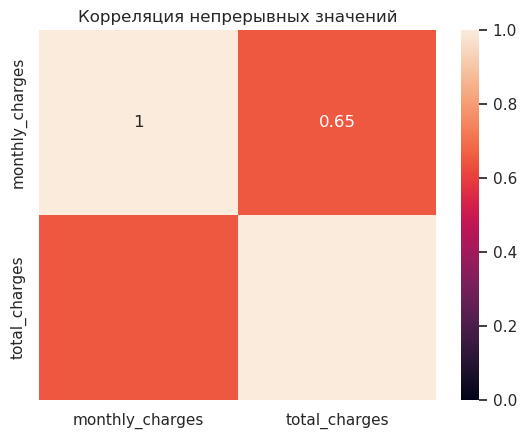

In [10]:
plt.title('Корреляция непрерывных значений')
sns.heatmap(data[['monthly_charges', 'total_charges']].corr(), 
            annot=True, vmin=0., vmax=1)
plt.show()

Значения месячных платежей и суммы платежей сильно коррелируют друг с другом. Можно попробовать убрать `total_charges`

Основная часть данных является категориальными. Чтобы исследовать их взаимосвязь, воспользуемся Cramer’s V статистикой.

In [11]:
def cramers_V(var1,var2):
    # Cross table building
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) 
    # Keeping of the test statistic of the Chi2 test
    stat = chi2_contingency(crosstab)[0] 
    # Number of observations
    obs = np.sum(crosstab)
    # Take the minimum value between the columns and the rows of the cross table
    mini = min(crosstab.shape)-1
    return np.sqrt(stat/(obs*mini))

In [12]:
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in data.select_dtypes(include=["object","int64"]).columns :
    data_encoded[i]=label.fit_transform(data[i])

In [13]:
data_encoded.head()

,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target
0,0,1,2,0,0,1,0,0,0,1,0,0,0,0,0,0
1,1,0,3,1,0,0,0,0,1,0,1,0,0,0,0,0
2,0,1,3,1,0,0,0,0,1,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0
4,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,1


In [14]:
rows= []

for var1 in data_encoded:
    col = []
    for var2 in data_encoded :
        cramers = cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, 
                  columns=data_encoded.columns, 
                  index=data_encoded.columns)
df

,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,target
type,1.00,0.18,0.27,0.01,0.14,0.30,0.24,0.21,0.25,0.16,0.23,0.30,0.11,0.12,0.11,0.41
paperless_billing,0.18,1.00,0.25,0.01,0.16,0.01,0.11,0.38,0.00,0.13,0.10,0.04,0.22,0.21,0.16,0.19
payment_method,0.27,0.25,1.00,0.02,0.20,0.16,0.15,0.31,0.18,0.19,0.21,0.18,0.25,0.25,0.23,0.30
gender,0.01,0.01,0.02,1.00,0.00,0.00,0.01,0.01,0.02,0.01,0.00,0.01,0.01,0.01,0.01,0.01
senior_citizen,0.14,0.16,0.20,0.00,1.00,0.02,0.21,0.27,0.04,0.07,0.06,0.06,0.10,0.12,0.14,0.15
partner,0.30,0.01,0.16,0.00,0.02,1.00,0.45,0.00,0.14,0.14,0.15,0.12,0.12,0.12,0.14,0.15
dependents,0.24,0.11,0.15,0.01,0.21,0.45,1.00,0.18,0.08,0.02,0.01,0.06,0.02,0.04,0.02,0.16
internet_service,0.21,0.38,0.31,0.01,0.27,0.00,0.18,1.00,0.39,0.38,0.38,0.39,0.44,0.44,0.37,0.32
online_security,0.25,0.00,0.18,0.02,0.04,0.14,0.08,0.39,1.00,0.28,0.28,0.35,0.18,0.19,0.10,0.17
online_backup,0.16,0.13,0.19,0.01,0.07,0.14,0.02,0.38,0.28,1.00,0.30,0.29,0.28,0.27,0.20,0.08


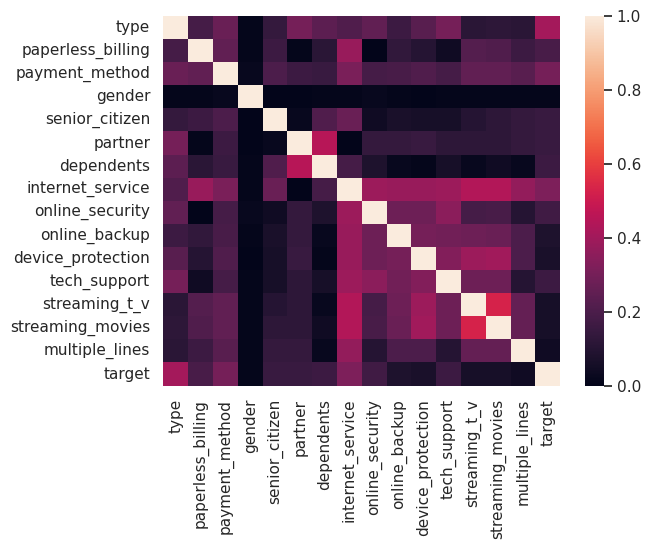

In [16]:
# plt.title('Корреляция категориальных значений')
sns.heatmap(df, vmin=0., vmax=1, annot=False)
plt.show()

* Видно, что наличие партнера слабо коррелирует с наличием иждивенцев. 

* Наличие подписки на интернет слабо коррелирует со всеми остальными признакими. Исключениями являются гендер и наличие партнера. 

* Метод платежа очень слабо коррелирует со всеми данными.

* Уход клиента слабо коррелирует с типом и методом оплаты подписок, а также наличием подписки на итернет.

* Средняя корреляция наблюдается только между наличием услуги стриммингового телевидения и услуги стриммингового кино. 

### Визуализируем категориальные признаки

In [20]:
len(data.select_dtypes(include=["object","int64"]).columns)-1

15

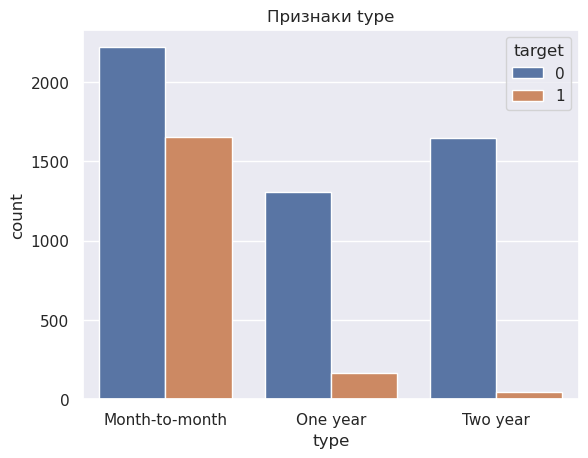

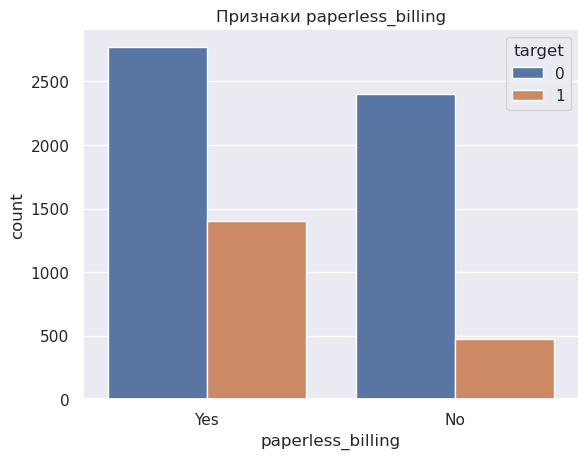

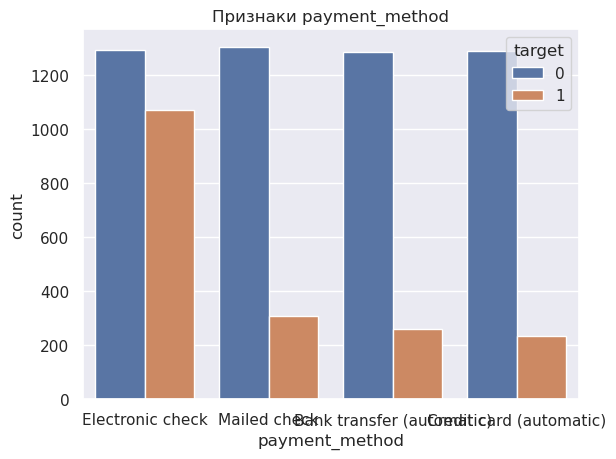

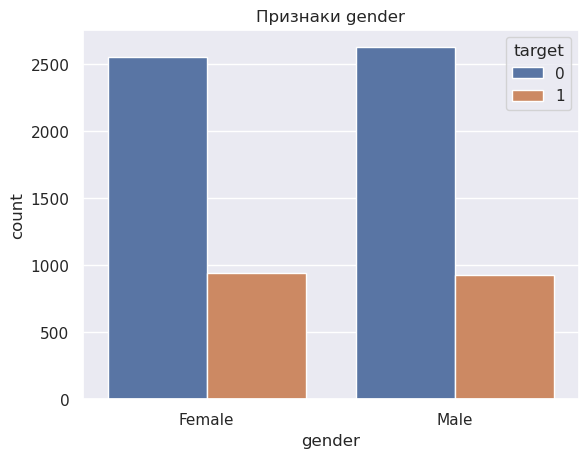

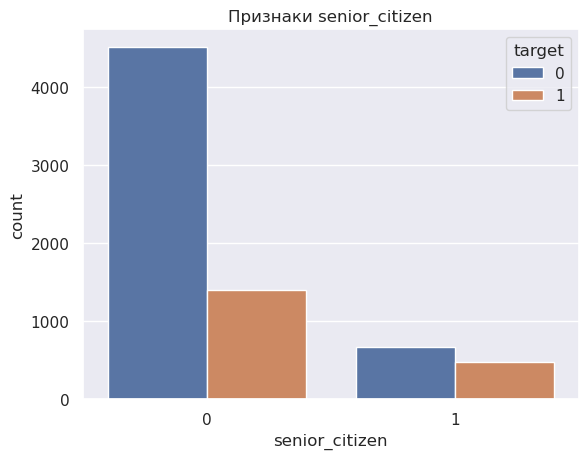

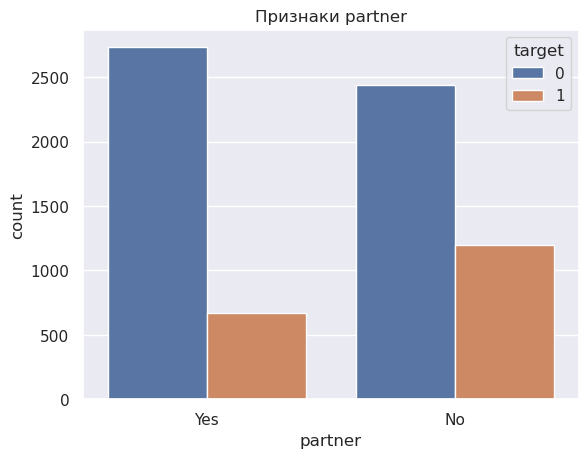

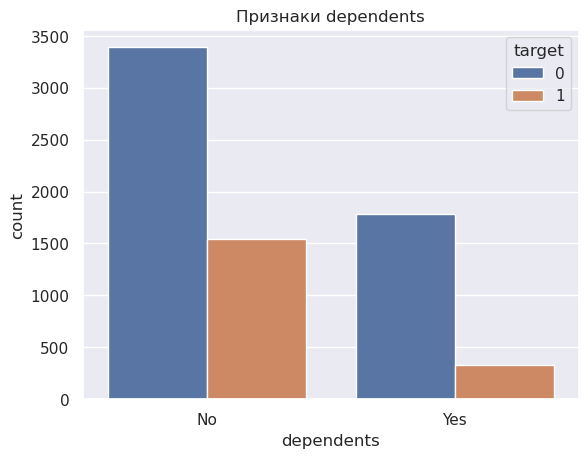

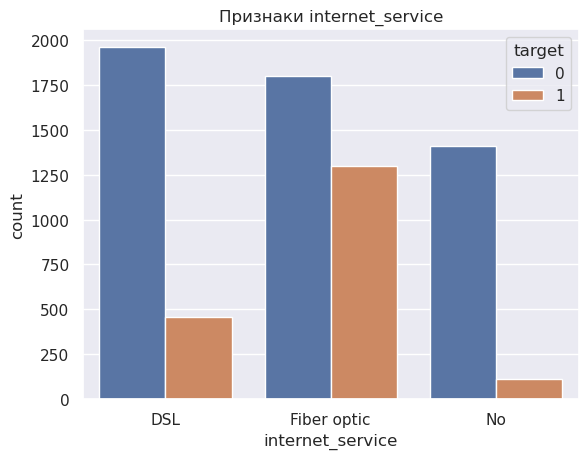

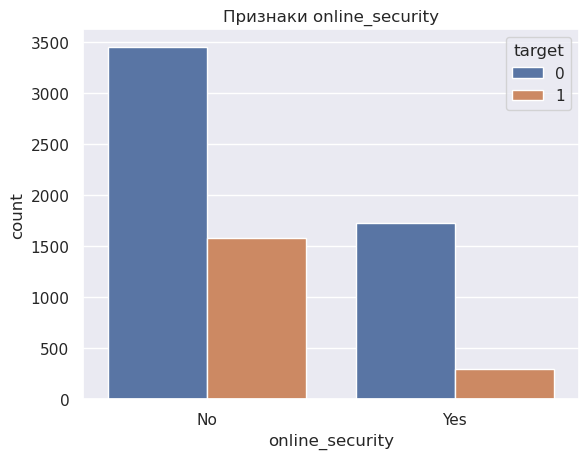

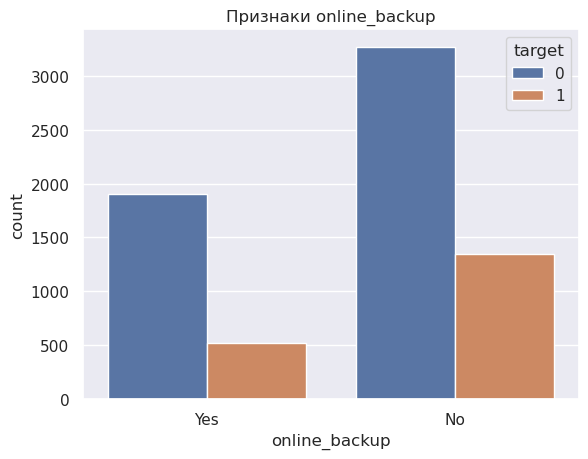

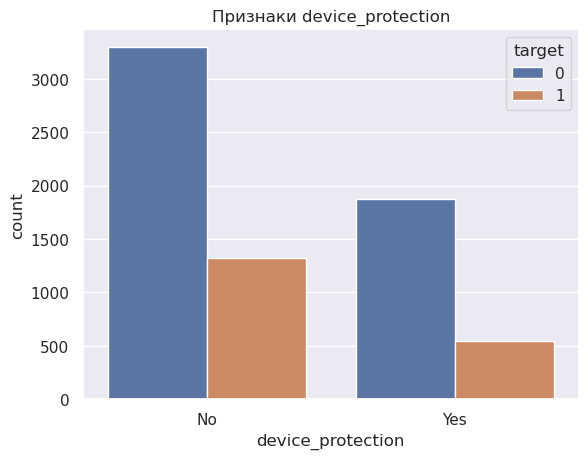

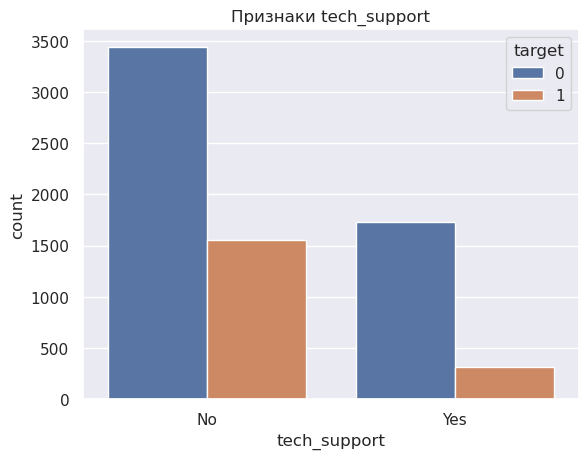

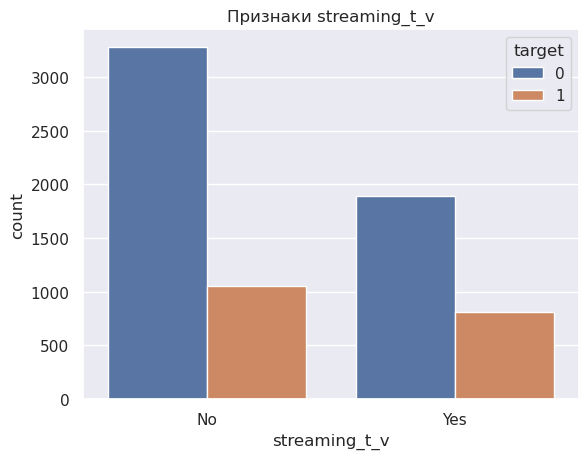

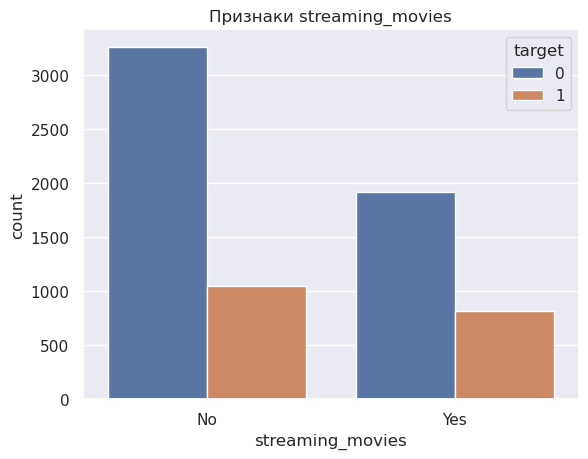

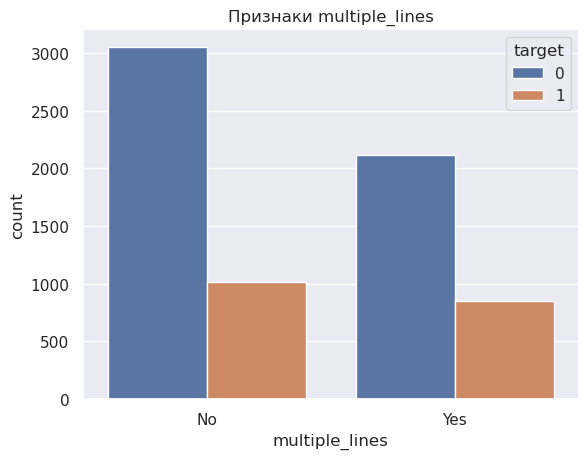

In [34]:
for col in data.select_dtypes(include=["object","int64"]).columns[:-1]:
    
    plt.title(f'Признаки {col}')
    sns.countplot(x=data[col], hue=data['target'].astype("str"))
    plt.show()

* Необходимость платить за услуги каждый месяц увеличивает шанс ухода клиента

* Электронный платеж способствует уходу клиента

* Среди ушедших клиентов много пользователей оптоволоконного интернета

* Пользователи без онлайн бекапа чаще уходят от компании

* Техническая поддержка удерживает клиентов

### Проанализируем ежемесячные платежи.

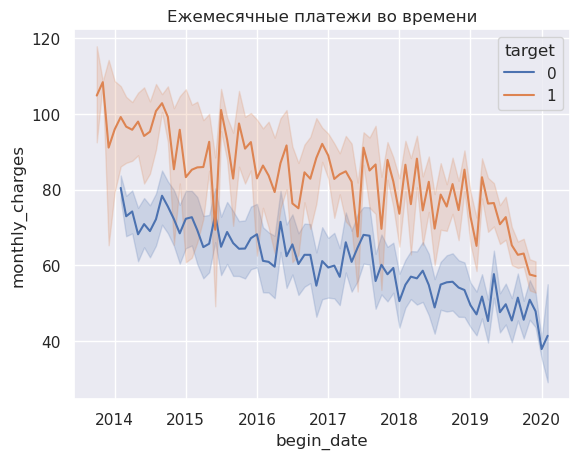

In [35]:
plt.title('Ежемесячные платежи во времени')
sns.lineplot(x="begin_date", y="monthly_charges",
             hue="target", data=data)
plt.show()

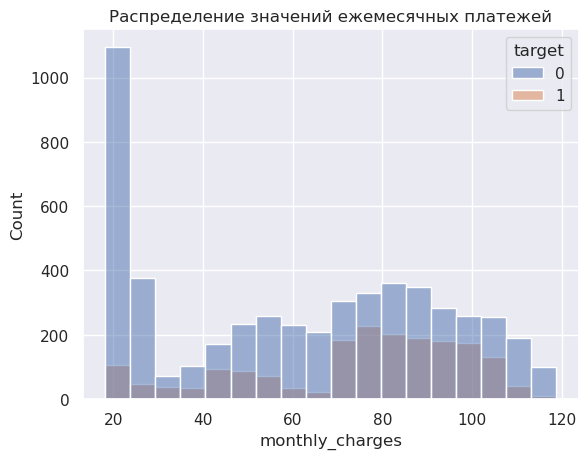

In [36]:
plt.title('Распределение значений ежемесячных платежей')
sns.histplot(data=data, x='monthly_charges', hue='target')
plt.show()

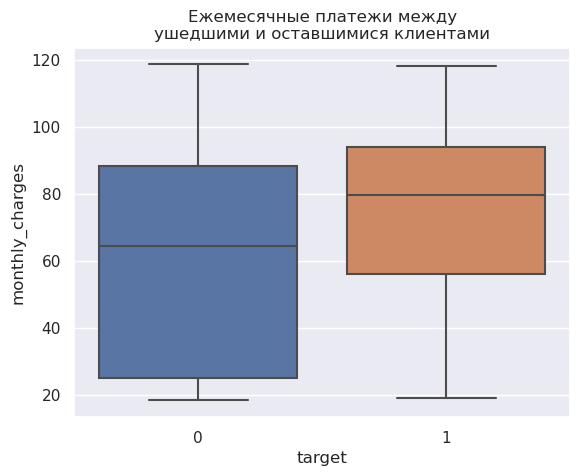

In [37]:
plt.title('Ежемесячные платежи между\nушедшими и оставшимися клиентами')
sns.boxplot(x="target", y="monthly_charges",
            data=data)
plt.show()

* Странно, что платежи становятся меньше со временем. 

* У ушедших клиентов цены услуги компании были незначительно дороже.

* В данных нет информации об активных клиентах компании, которые начали пользоваться услугами до 2014.

### Добавим новую колонку, содержащую в себе данные о том, как долго клиент пользуется услугами компании

Так как информация о договорах актуальна на 1 февраля 2020, заменим пропуски в `end_date` на эту дату.

In [38]:
data['end_date'] = data['end_date'].fillna('2020-02-01')
data['end_date'] = pd.to_datetime(data['end_date'], yearfirst=True)

data['interactions'] = data['end_date'] - data['begin_date']

data['interactions'] = data['interactions'].dt.days
data['interactions']

customerID
7590-VHVEG      31
5575-GNVDE    1036
3668-QPYBK      61
7795-CFOCW    1371
9237-HQITU      61
              ... 
6840-RESVB     730
2234-XADUH    2191
4801-JZAZL     337
8361-LTMKD     123
3186-AJIEK    2010
Name: interactions, Length: 7043, dtype: int64

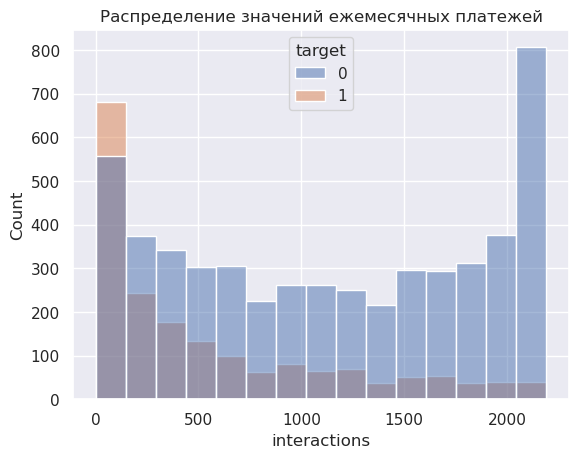

In [39]:
plt.title('Распределение значений ежемесячных платежей')
sns.histplot(data=data, x='interactions', hue='target')
plt.show()

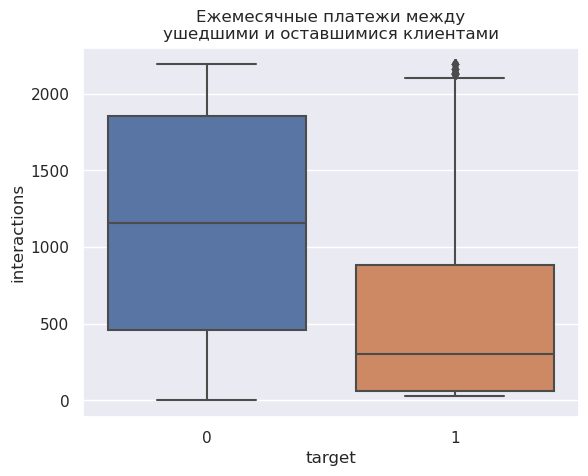

In [40]:
plt.title('Ежемесячные платежи между\nушедшими и оставшимися клиентами')
sns.boxplot(x="target", y="interactions",
            data=data)
plt.show()

* Чем дольше человек является клиентом компании, тем меньше вероятность того, что он разорвет контракт. 

* При этом, встречаются клиенты, которые уходят от компании как и в первые дни после подписания контракта, так и спустя годы взаимодействий.

Построим графики распределений количественных признаков

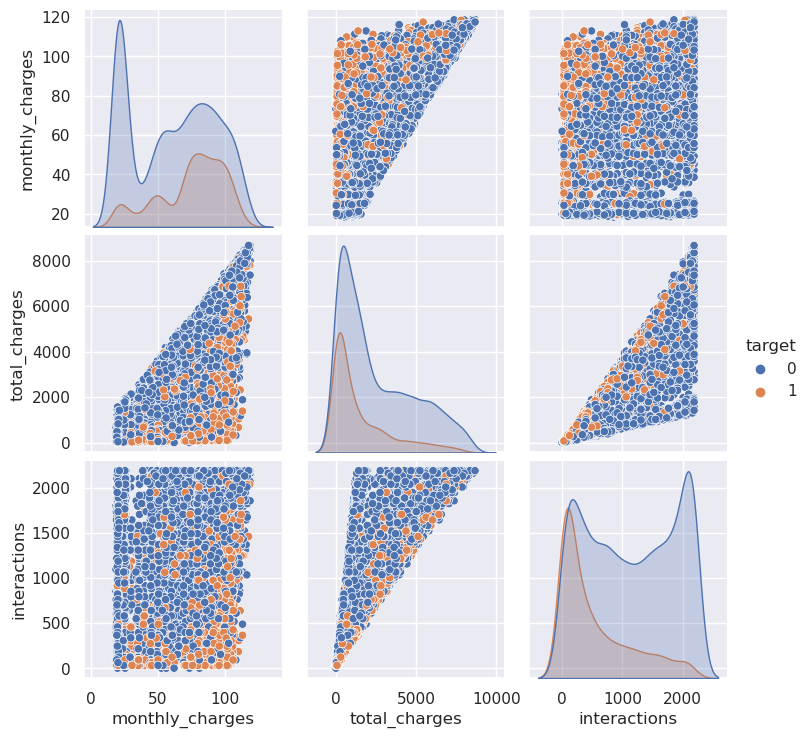

In [41]:
sns.pairplot(data[['monthly_charges', 'total_charges', 'interactions', 'target']],
             hue='target')
plt.show()

* Распределние `monthly_charges` двугорбое. Видно, что в группе оставшихся клиентов преобладают небольшие платежи. При этом у ушедших клиентов распределение смещается в сторону более крупных плаетжей.

* Распределение `total_charges` как у ушедших, так и оставшихся клиентов, смещены влево. Но у оставшихся клиентов количество наблюдений крупных суммарных платежей больше.

* Распределения длительности взаимоотношений клиентов с компанией сильно различаются. Для ушедших клиентов распределение смещено влево, преобладает малое количество дней действующего контракта. Для оставшихся клиентов распределение двугорбое, на нем видно разделение на старых и новых действующих клиентов.

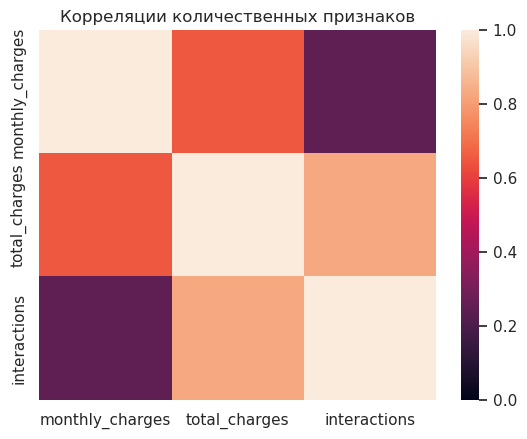

In [44]:
plt.title('Корреляции количественных признаков')
sns.heatmap(data[['monthly_charges', 'total_charges', 'interactions']].corr(),
            vmin=0, vmax=1)
plt.show()

Добавленный признак `interactions` сильно коррелирует с `total_charges`. При этом с признаком `monthly_charges` наблюдается лишь очень слабая корреляция. Данные наблюдения говорят о том, что признак `total_charges` можно убрать при обучении моделей.

## Разобьем данные на тренировочную и тестовую выборки

Уберем из данных информацию о датах подписания контракта и ухода клиента. Так как если заполнить в ней пропуски на дату последнего обновления данных, то произойдет их утечка. Кроме того, таким образом мы избавляемся от мультиколлинеарных векторов.

С другой стороны, информация о количестве активных дней контракта, не должна быть утечкой. Так как в выборке есть как старые клиенты, которые ушли, так и новые клиенты с действующими контрактами.

In [46]:
features = data.drop(['target', 'end_date', 'begin_date',
                      'total_charges'], axis=1)
target = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [47]:
print(X_train.shape, X_test.shape)

(5282, 17) (1761, 17)


## Обучение моделей

### Кодирование категориальных данных

Для логистической регрессии будем использовать `OneHotEncoder` в сочетании со `StandardScaler` для количественных данных.

Для моделей, основанных на деревьях, будем использовать только `OrdinalEncoder`.

Так как в выборке есть дисбаланс классов, увеличим недостающий класс в тренировочной выборке при помощи SMOTE в пайплайне.

In [48]:
cat_cols = list(data.select_dtypes(include=["object","int64"]).columns)
cat_cols.remove("interactions")
cat_cols.remove("target")
print("Категориальные признаки:", cat_cols)

Категориальные признаки: ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']


In [49]:
num_cols = ['monthly_charges', 'interactions']
print("Численные признаки:", num_cols)

Численные признаки: ['monthly_charges', 'interactions']


In [50]:
ohe_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_cols
    ),
    (
        StandardScaler(), 
        num_cols
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [51]:
oe_cat_cols = cat_cols.copy()
oe_cat_cols.remove('senior_citizen')

oe_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value',
                       unknown_value=-1, dtype='int64'), 
        oe_cat_cols
    ),
    remainder='passthrough'
)

### Логистическая регрессия

In [53]:
X_train_logreg = X_train.copy()

logreg_model = LogisticRegression(random_state=RANDOM_STATE)

In [62]:
pipeline_logreg = Pipeline(steps=[
                  ('preprocess', ohe_transformer),
                  ('model', logreg_model)
                                 ])

param_grid_logreg = {
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'model__C':[0.01, 0.3, 0.5, 1]
}

rs_logreg_pl = RandomizedSearchCV(
    pipeline_logreg, 
    param_distributions=param_grid_logreg, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=RANDOM_STATE,
    cv=5, verbose=1
)

rs_logreg_pl.fit(X_train_logreg, y_train)

rs_logreg_best_score = rs_logreg_pl.best_score_
rs_logreg_best_params = rs_logreg_pl.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {rs_logreg_best_score}')
# лучшие гиперпараметры
print(f'best_params: {rs_logreg_best_params}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_score: 0.8491789408312922
best_params: {'model__solver': 'newton-cg', 'model__C': 1}


### Случайный лес

In [63]:
X_train_rf = X_train.copy()

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

In [64]:
pipeline_rf = Pipeline(steps=[
                  ('preprocess', oe_transformer), 
                  ('model', rf_model)
                                 ])

param_grid_rf = {
    'model__n_estimators': range(50, 251, 50),
    'model__max_depth': range(2, 15),
    'model__min_samples_split': (2, 3, 4),
    'model__min_samples_leaf': (1, 2, 3, 4)
}

rs_rf_pl = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=4, 
    random_state=RANDOM_STATE,
    cv=5, verbose=1
)

rs_rf_pl.fit(X_train_rf, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(dtype='int64',
                                                                                              handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'gender',
                                                                                'partner',
                                                                                'dependents',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'online_backup',
                                                                                'device_protection',
                                                                                'tech_support',
                                                                                'streaming_t_v',
                                                                                'streaming_movies',
                                                                                'multiple_lines'])])),
                                             ('model',
                                              RandomForestClassifier(random_state=270223))]),
                   n_jobs=4,
                   param_distributions={'model__max_depth': range(2, 15),
                                        'model__min_samples_leaf': (1, 2, 3, 4),
                                        'model__min_samples_split': (2, 3, 4),
                                        'model__n_estimators': range(50, 251, 50)},
                   random_state=270223, scoring='roc_auc', verbose=1)

In [65]:
rs_rf_best_score = rs_rf_pl.best_score_
rs_rf_best_params = rs_rf_pl.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {rs_rf_best_score}')
# лучшие гиперпараметры
print(f'best_params: {rs_rf_best_params}')

best_score: 0.8665887547743625
best_params: {'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 7}


### Градиентный бустинг CatBoost

In [71]:
cbc = CatBoostClassifier(random_seed=RANDOM_STATE, cat_features=cat_cols,
                         loss_function="Logloss",
                         eval_metric="AUC:hints=skip_train~false",
                         metric_period=25,
                         logging_level="Silent")


param_grid_cbc = {'depth' : [4,5,6,7,8,9,10],
                  'iterations' : [50,60,70,80,90,100],
                  'learning_rate': [0.03, 0.1, 0.3, 0.5],
                  'l2_leaf_reg': [0.1, 3, 5, 7, 9]
                 }

grid_search_result = cbc.randomized_search(param_grid_cbc,
                                           X=X_train_rf,
                                           y=y_train,
                                           partition_random_seed=RANDOM_STATE,
                                           cv=5, verbose=1
                                       )



0:	loss: 0.8731260	best: 0.8731260 (0)	total: 195ms	remaining: 1.75s
1:	loss: 0.8754646	best: 0.8754646 (1)	total: 391ms	remaining: 1.56s
2:	loss: 0.9093508	best: 0.9093508 (2)	total: 660ms	remaining: 1.54s
3:	loss: 0.9060227	best: 0.9093508 (2)	total: 824ms	remaining: 1.24s
4:	loss: 0.8818081	best: 0.9093508 (2)	total: 1.05s	remaining: 1.05s
5:	loss: 0.8803160	best: 0.9093508 (2)	total: 1.4s	remaining: 930ms
6:	loss: 0.8830879	best: 0.9093508 (2)	total: 1.76s	remaining: 757ms
7:	loss: 0.8822101	best: 0.9093508 (2)	total: 2.11s	remaining: 527ms
8:	loss: 0.8877071	best: 0.9093508 (2)	total: 2.79s	remaining: 310ms
9:	loss: 0.8640352	best: 0.9093508 (2)	total: 3.64s	remaining: 0us
Estimating final quality...


In [72]:
rs_cbc_best_score = cbc.best_score_.get('learn').get('AUC')
rs_cbc_best_params = cbc.get_params()

# лучшее значение AUC на кросс-валидации
print(f'best_score: {rs_cbc_best_score}')
# лучшие гиперпараметры
print(f'best_params: {rs_cbc_best_params}')

best_score: 0.9199375708746931
best_params: {'loss_function': 'Logloss', 'random_seed': 270223, 'logging_level': 'Silent', 'metric_period': 25, 'eval_metric': 'AUC:hints=skip_train~false', 'cat_features': ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines'], 'depth': 5, 'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 100}


### Сравнение обученных моделей

In [73]:
d = {'LogReg': [rs_logreg_best_score], 
     'RandomForest': [rs_rf_best_score],
     'CatBoost': [rs_cbc_best_score]}
pd.DataFrame(d)

,LogReg,RandomForest,CatBoost
0,0.849179,0.866589,0.919938


 Лучше всего работает модель градиентного бустинга CatBoost. 

На тестовой выборке проверим работу модели градиентного бустинга CatBoost.

## Тест CatBoost

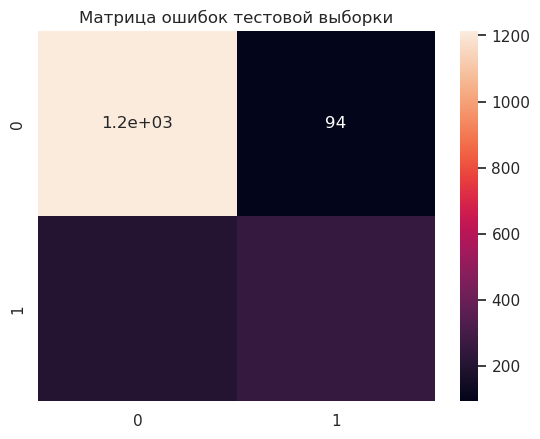

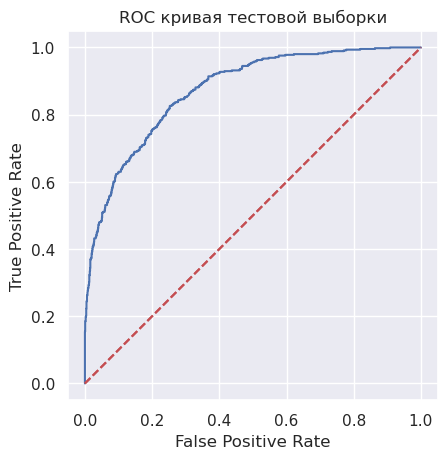

ROC-AUC тестовой выборки: 0.8730514107364951
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1307
           1       0.73      0.56      0.63       454

    accuracy                           0.83      1761
   macro avg       0.79      0.74      0.76      1761
weighted avg       0.82      0.83      0.82      1761



In [74]:
predictions = cbc.predict(X_test)
probas = cbc.predict_proba(X_test)[::,1]

# calculate ROC
fpr, tpr, _ = roc_curve(y_test, probas)
  
# calculate confusion matrix
cf_matrix_train = confusion_matrix(y_test, predictions)

# plot confusion matrix
sns.heatmap(cf_matrix_train, annot=True)
plt.title(f'Матрица ошибок тестовой выборки')
plt.show()

#create ROC curve
plt.plot(fpr,tpr)
plt.plot(np.array([[0,0], [1,1]]), "k--", c='r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ROC кривая тестовой выборки')
plt.axis("square")
plt.show()

  
# print metrics
print(f"ROC-AUC тестовой выборки: {roc_auc_score(y_test, probas)}")
print("==="*20)
print(classification_report(y_test, predictions))

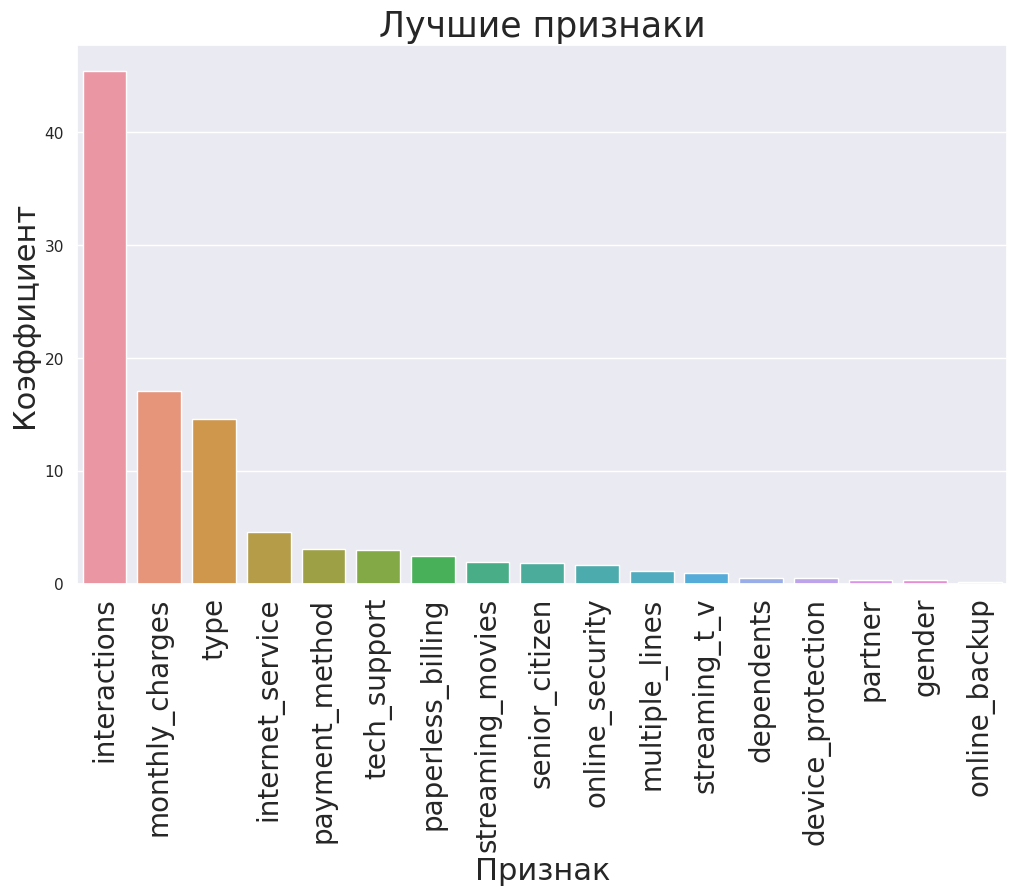

In [75]:
pool_data = X_test.copy()
cbc_pool = Pool(pool_data,
           label=y_test,
           cat_features=cat_cols,
           )

df = pd.DataFrame({'feature_importance': cbc.get_feature_importance(cbc_pool), 
              'feature_names': X_train_rf.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
# df
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature_names",
            y="feature_importance",
            data=df.head(20),
#            palette=df.head(20)["colors"]
           )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Лучшие признаки", fontsize=25)
ax.set_ylabel("Коэффициент", fontsize=22)
ax.set_xlabel("Признак", fontsize=22)
plt.show()

### Вывод 

* В ходе работы были проанализированы данные клиентов оператора связи.

* Была решена задача бинарной классификации

* Ключевая метрика ROC-AUC была достигнута на уровне 0.8748 при помощи модели градиентного бустинга CatBoost Classifier.

* Наиболее важными признаками явлыются `interactions`, `monthly_charges` и `type`.

## Отчет

* В ходе работы был проведен анализ 7043 клиентов оператора связи «Ниединогоразрыва.ком», обучены модели логистической регрессии, случайного леса и градиентного бустинга CatBoost. Лучшей моделью стал градиентный бустинг CatBoost Classifier. Ключевая метрика ROC-AUC была достигнута на уровне 0.8748.

* Среди трудностей, возникших в ходе работы, можно выделить то, что данные о клиентах были предоставлены в разных таблицах. При объединении таблиц нельзя было потерять клиентов. Также большинство признаков в таблице являются категориальными. Перед обучением модели нужно было использовать правильные энкодеры. Кроме того, в выборке существует дисбаланс классов. Эта проблема была решена на этапе постановки ключевой метрики. ROC-AUC не чувствителен к дисбалансу классов.

* Ключевые шаги при обучении моделей состояли из разделения выборки на тренировочную и тестовую. На тренировочной выборки осуществлялось кодирование категориальных признаков, подбор гиперпараметров с кроссвалидацией. Проверка работы лучшей модели происходила на тестовой выборке.

* Для обучения модели использовались признаки `'type'`, `'paperless_billing'`, `'payment_method'`, `'monthly_charges'`, `'gender'`, `'senior_citizen'`, `'partner'`, `'dependents'`, `'internet_service'`, `'online_security'`, `'online_backup'`, `'device_protection'`, `'tech_support'`, `'streaming_t_v'`, `'streaming_movies'`, `'multiple_lines'` и `'interactions'`. Наиболее важными являются `'interactions'`, `'monthly_charges'` и `'type'`. `'interactions'` это сгенерированный признак, означающий количество дней действующего контракта клиента и компании.

* Итоговвая модель является моделью градиентного бустинга CatBoost. Параметры модели: `{'loss_function': 'Logloss', 'random_seed': 270223, 'metric_period': 25, 'eval_metric': 'AUC:hints=skip_train~false', 'cat_features': ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines'], 'depth': 5, 'l2_leaf_reg': 3, 'iterations': 100, 'learning_rate': 0.3}`.
Ключевая метрика ROC-AUC: 0.873
